# 安徽安庆市项目`WRF-CMAQ`模拟分析
## 模拟结果分析：*`Integrated Source Apportionment Method`*

---
*@author: Evan*\
*@date: 2023-06-12*

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',
    "mathtext.fontset":'stix',
    "font.serif": ['SimSun'],
}
rcParams.update(config)

# silence the warning note
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../../src/')
import ModelEvaLib as me
from namelist import *

## 读取数据

In [2]:
isamfiles = [isam_PMfile1,isam_PMfile2]
isam = xr.open_mfdataset(isamfiles,combine='nested',concat_dim='time')
isam

<xarray.Dataset>
Dimensions:    (time: 744, level: 26, y: 138, x: 135)
Coordinates:
  * time       (time) datetime64[ns] 2023-05-01 ... 2023-05-31T23:00:00
  * level      (level) float64 1e+03 998.0 995.8 993.4 ... 703.9 659.0 616.2
    latitude   (y, x) float32 dask.array<chunksize=(138, 135), meta=np.ndarray>
    longitude  (y, x) float32 dask.array<chunksize=(138, 135), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    PM_AnQ     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_AQI     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_AQT     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_AQA     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_OTH     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_ICO     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
    PM_BCO     (time, level, y, x) float32 dask.array<chunksize=(360, 26, 138, 135), meta=np.ndarray>
Attributes:
    case:     Anqing_202305
    grid:     CN3AH_135X138

In [3]:
# 计算L1和L2两层平均数据
# 获取需要遍历的变量列表和相应的变量名称列表
var_list = [isam.PM_AnQ, isam.PM_AQI, isam.PM_AQT, isam.PM_AQA, 
            isam.PM_OTH, isam.PM_ICO, isam.PM_BCO]
name_list = ['AnQ', 'AQI', 'AQT', 'AQA', 'OTH', 'ICO', 'BCO']

# 初始化 L1 和 L2 变量字典
L1_dict = {}
L2_dict = {}

for i, var in enumerate(var_list):
    # 在 L1 字典中存储 L1 变量
    L1_dict[f"{name_list[i]}_L1"] = var[:,0,:,:]
    # L1_dict[f"{name_list[i]}_L1"] = np.mean(var[:,:4,:,:], axis=1)
    
    # 在 L2 字典中存储 L2 变量
    L2_dict[f"{name_list[i]}_L2"] = np.mean(var[:,4:19,:,:], axis=1)

# 解包 L1 和 L2 字典，将变量重新赋值给原始变量名称
AnQ_L1, AQI_L1, AQT_L1, AQA_L1, OTH_L1, ICO_L1, BCO_L1 = L1_dict.values()
AnQ_L2, AQI_L2, AQT_L2, AQA_L2, OTH_L2, ICO_L2, BCO_L2 = L1_dict.values()


In [4]:
import geopandas as gpd
import shapely.geometry as sgeom
from shapely.prepared import prep

def polygon_to_mask(polygon, x, y):
    '''
    Generate a mask array of points falling into the polygon
    '''
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    mask = np.zeros(x.shape, dtype=bool)

    # if each point falls into a polygon, without boundaries
    prepared = prep(polygon)
    for index in np.ndindex(x.shape):
        point = sgeom.Point(x[index], y[index])
        if prepared.contains(point):
            mask[index] = True

    return mask

In [5]:
lon = isam.longitude
lat = isam.latitude
shp_urban = gpd.read_file(shpurban)

mask = polygon_to_mask(shp_urban.geometry[0],lon,lat)
mask_da = xr.DataArray(mask,dims=('y','x'))

masked_AnQ = AnQ_L1.where(mask_da)
AnQ_mean   = masked_AnQ.mean(dim=['y','x'],skipna=True)

masked_AQI = AQI_L1.where(mask_da)
AQI_mean   = masked_AQI.mean(dim=['y','x'],skipna=True)

masked_AQT = AQT_L1.where(mask_da)
AQT_mean   = masked_AQT.mean(dim=['y','x'],skipna=True)

masked_AQA = AQA_L1.where(mask_da)
AQA_mean   = masked_AQA.mean(dim=['y','x'],skipna=True)

masked_OTH = OTH_L1.where(mask_da)
OTH_mean   = masked_OTH.mean(dim=['y','x'],skipna=True)

masked_BCO = BCO_L1.where(mask_da)
BCO_mean   = masked_BCO.mean(dim=['y','x'],skipna=True)

masked_ICO = ICO_L1.where(mask_da)
ICO_mean   = masked_ICO.mean(dim=['y','x'],skipna=True)


In [6]:
timeindex = pd.date_range('2023-05-01T00','2023-05-31T23',freq='h')
df_L1 = pd.DataFrame(
    index=timeindex,
    data={'AnQ':AnQ_mean,'AQI':AQI_mean,'AQT':AQT_mean,'AQA':AQA_mean,
          'OTH':OTH_mean,'BCO':BCO_mean,'ICO':ICO_mean}
    )
df_avg = df_L1.resample('D').mean()

## 画图

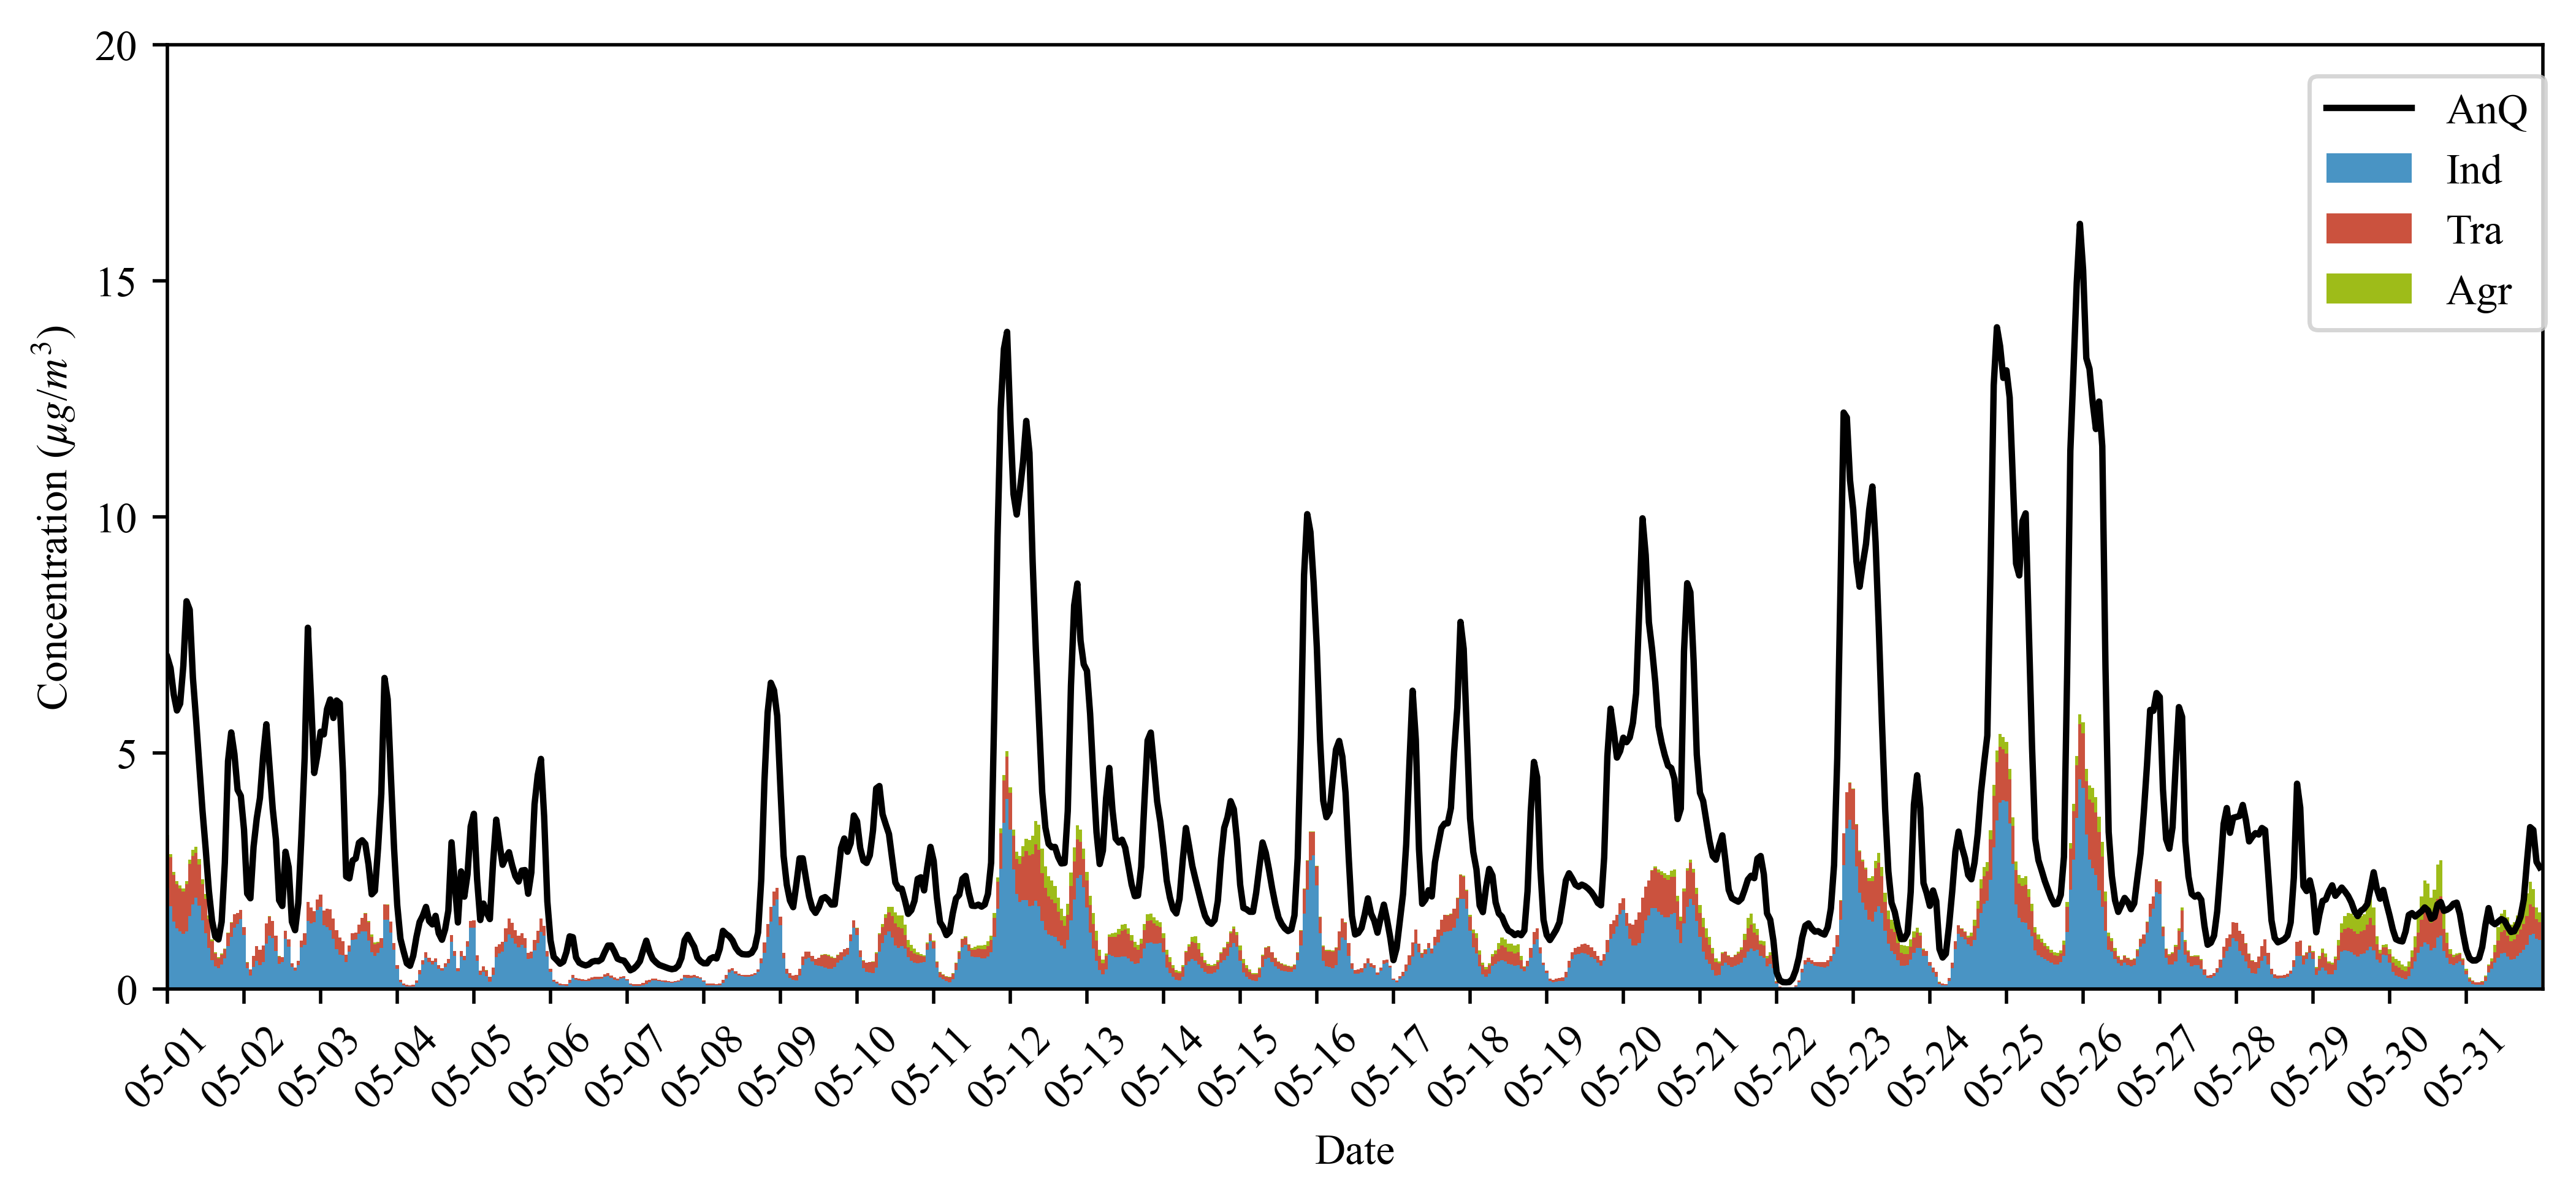

In [8]:
ts=np.arange(0,744)

colors = ['#4994c4','#cb523e','#9ebc19','#a2d2e2',
          '#d9883d','#ba79b1','#c8b5b3','#45465e']

fig,ax =plt.subplots(figsize=(10,4),dpi=500)

l1 = ax.plot(ts,df_L1['AnQ'],color='k')

b1=ax.bar(ts,df_L1['AQI'],color=colors[0],width=1)
b2=ax.bar(ts,df_L1['AQT'],bottom=df_L1['AQI'],color=colors[1],width=1)
b3=ax.bar(ts,df_L1['AQA'],bottom=df_L1['AQT']+df_L1['AQI'],color=colors[2],width=1)

ax.legend((l1[0],b1[0],b2[0],b3[0]),
          ('AnQ','Ind','Tra','Agr'),bbox_to_anchor=(1.01,0.99))
# ax.set_title('O$_3$ in urban Anqing',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,744,24))
ax.set_xticklabels(pd.date_range('2023-05-01','2023-05-31',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,21,5))
ax.set_ylim(0,20)
ax.set_xlim(0,744)

plt.show()

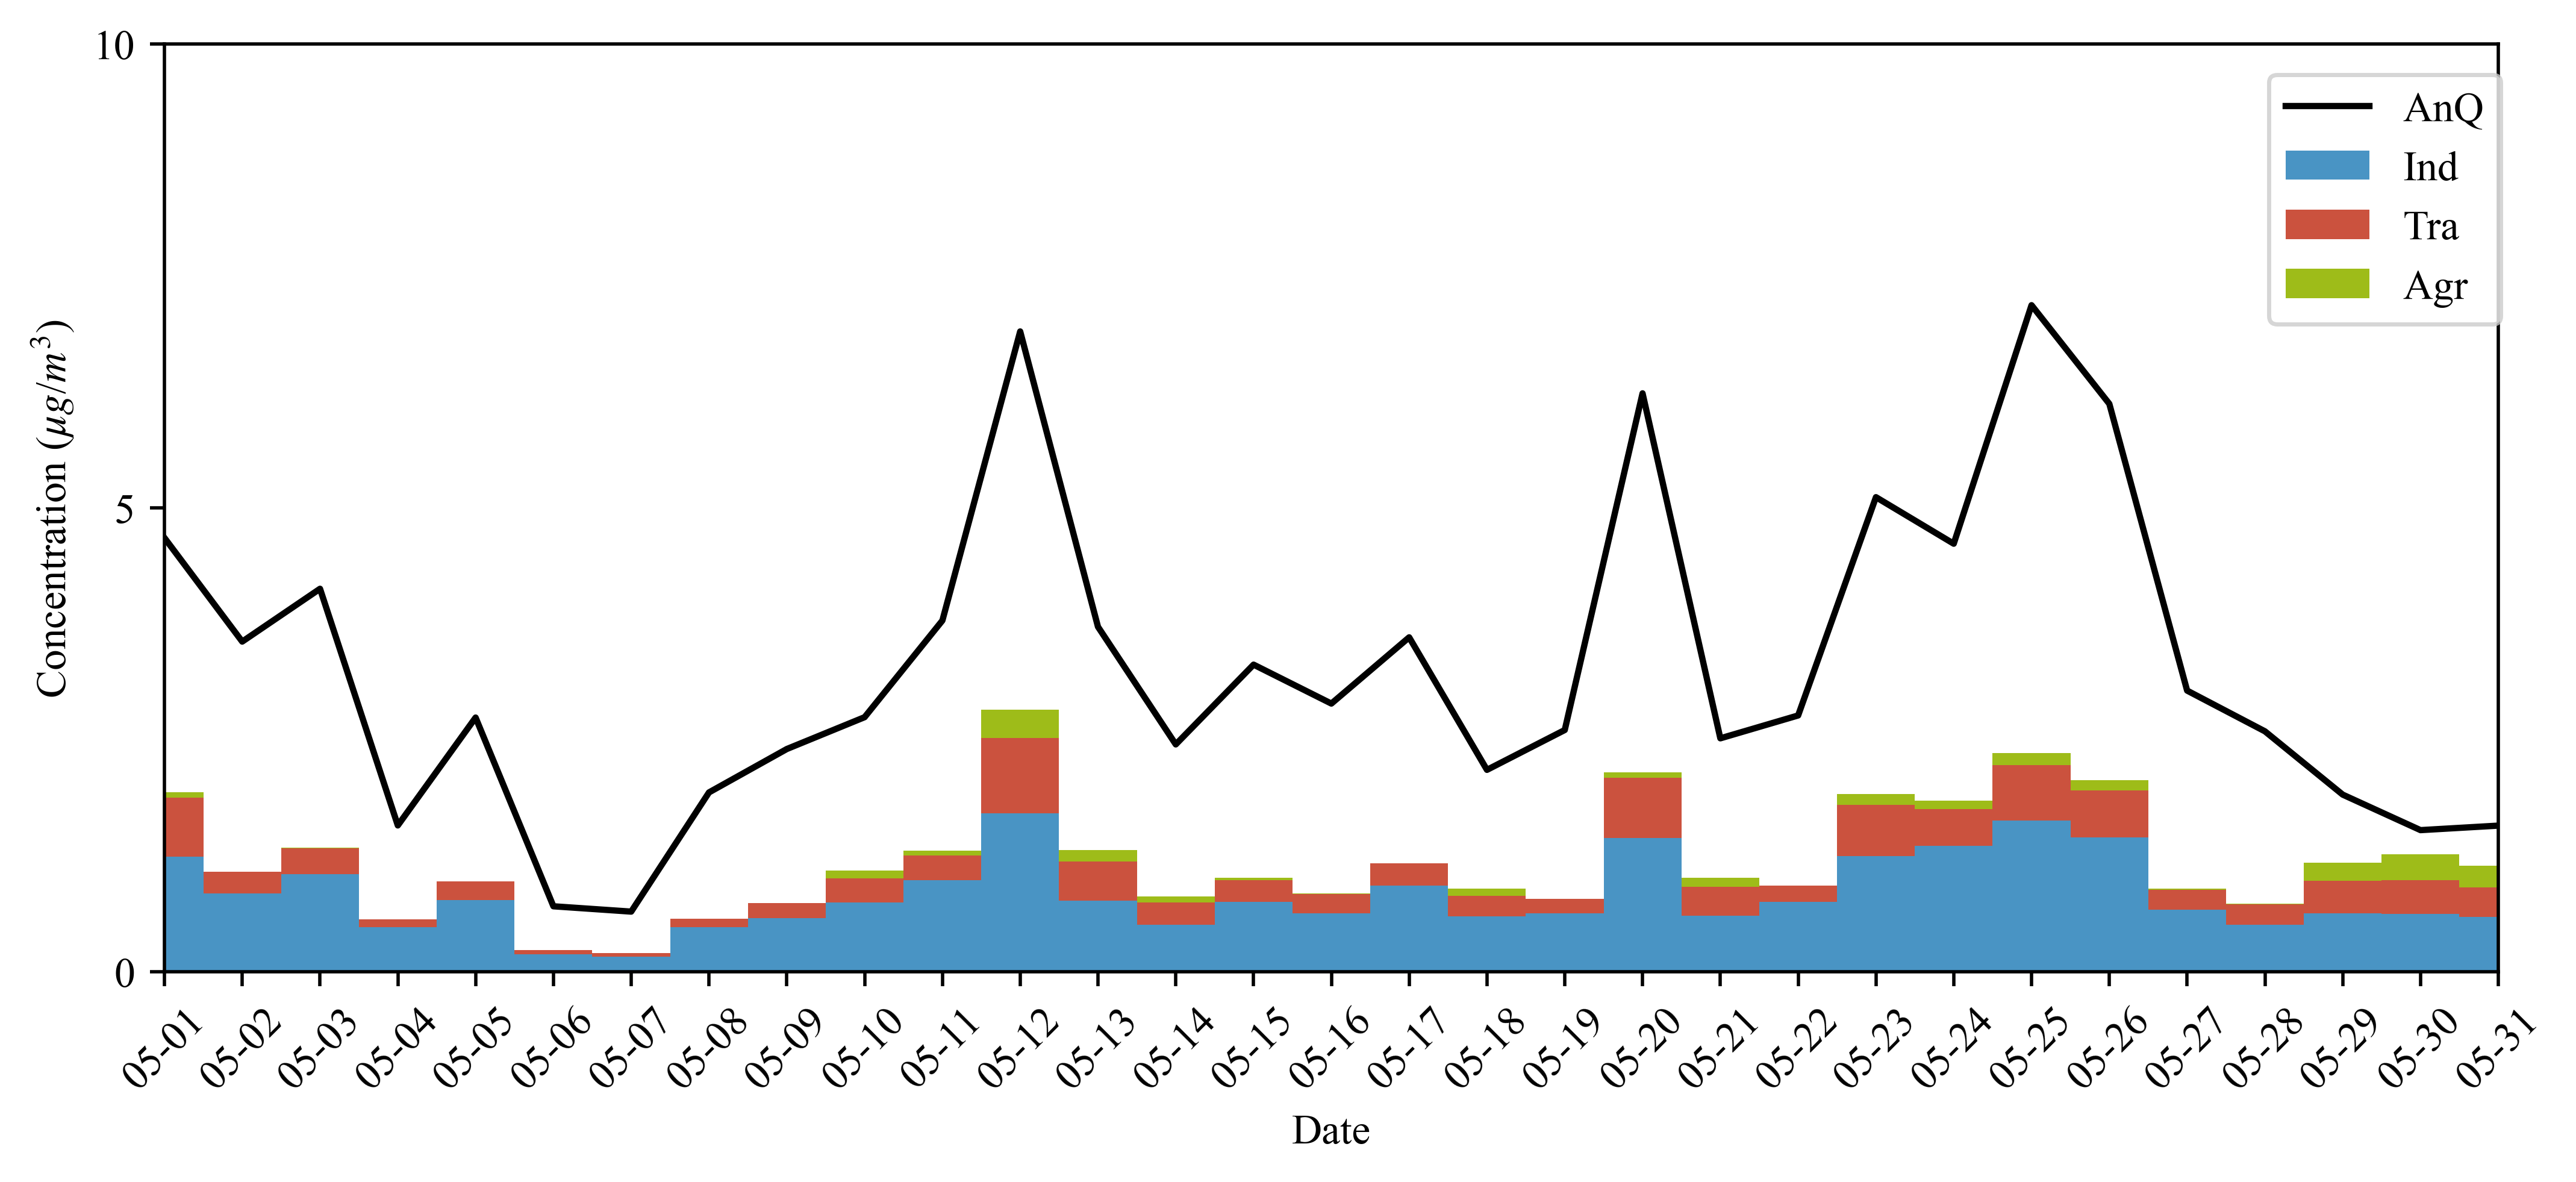

In [10]:
ts=np.arange(0,31)

colors = ['#4994c4','#cb523e','#9ebc19','#a2d2e2',
          '#d9883d','#ba79b1','#c8b5b3','#45465e']

fig,ax =plt.subplots(figsize=(10,4),dpi=500)

l1 = ax.plot(ts,df_avg['AnQ'],color='k')

b1=ax.bar(ts,df_avg['AQI'],color=colors[0],width=1)
b2=ax.bar(ts,df_avg['AQT'],bottom=df_avg['AQI'],color=colors[1],width=1)
b3=ax.bar(ts,df_avg['AQA'],bottom=df_avg['AQT']+df_avg['AQI'],color=colors[2],width=1)

ax.legend((l1[0],b1[0],b2[0],b3[0]),
          ('AnQ','Ind','Tra','Agr'),bbox_to_anchor=(1.01,0.99))
# ax.set_title('O$_3$ in urban Anqing',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,31))
ax.set_xticklabels(pd.date_range('2023-05-01','2023-05-31',freq='D').strftime('%m-%d'),rotation=45)
ax.set_yticks(np.arange(0,11,5))
ax.set_ylim(0,10)
ax.set_xlim(0,30)

plt.show()

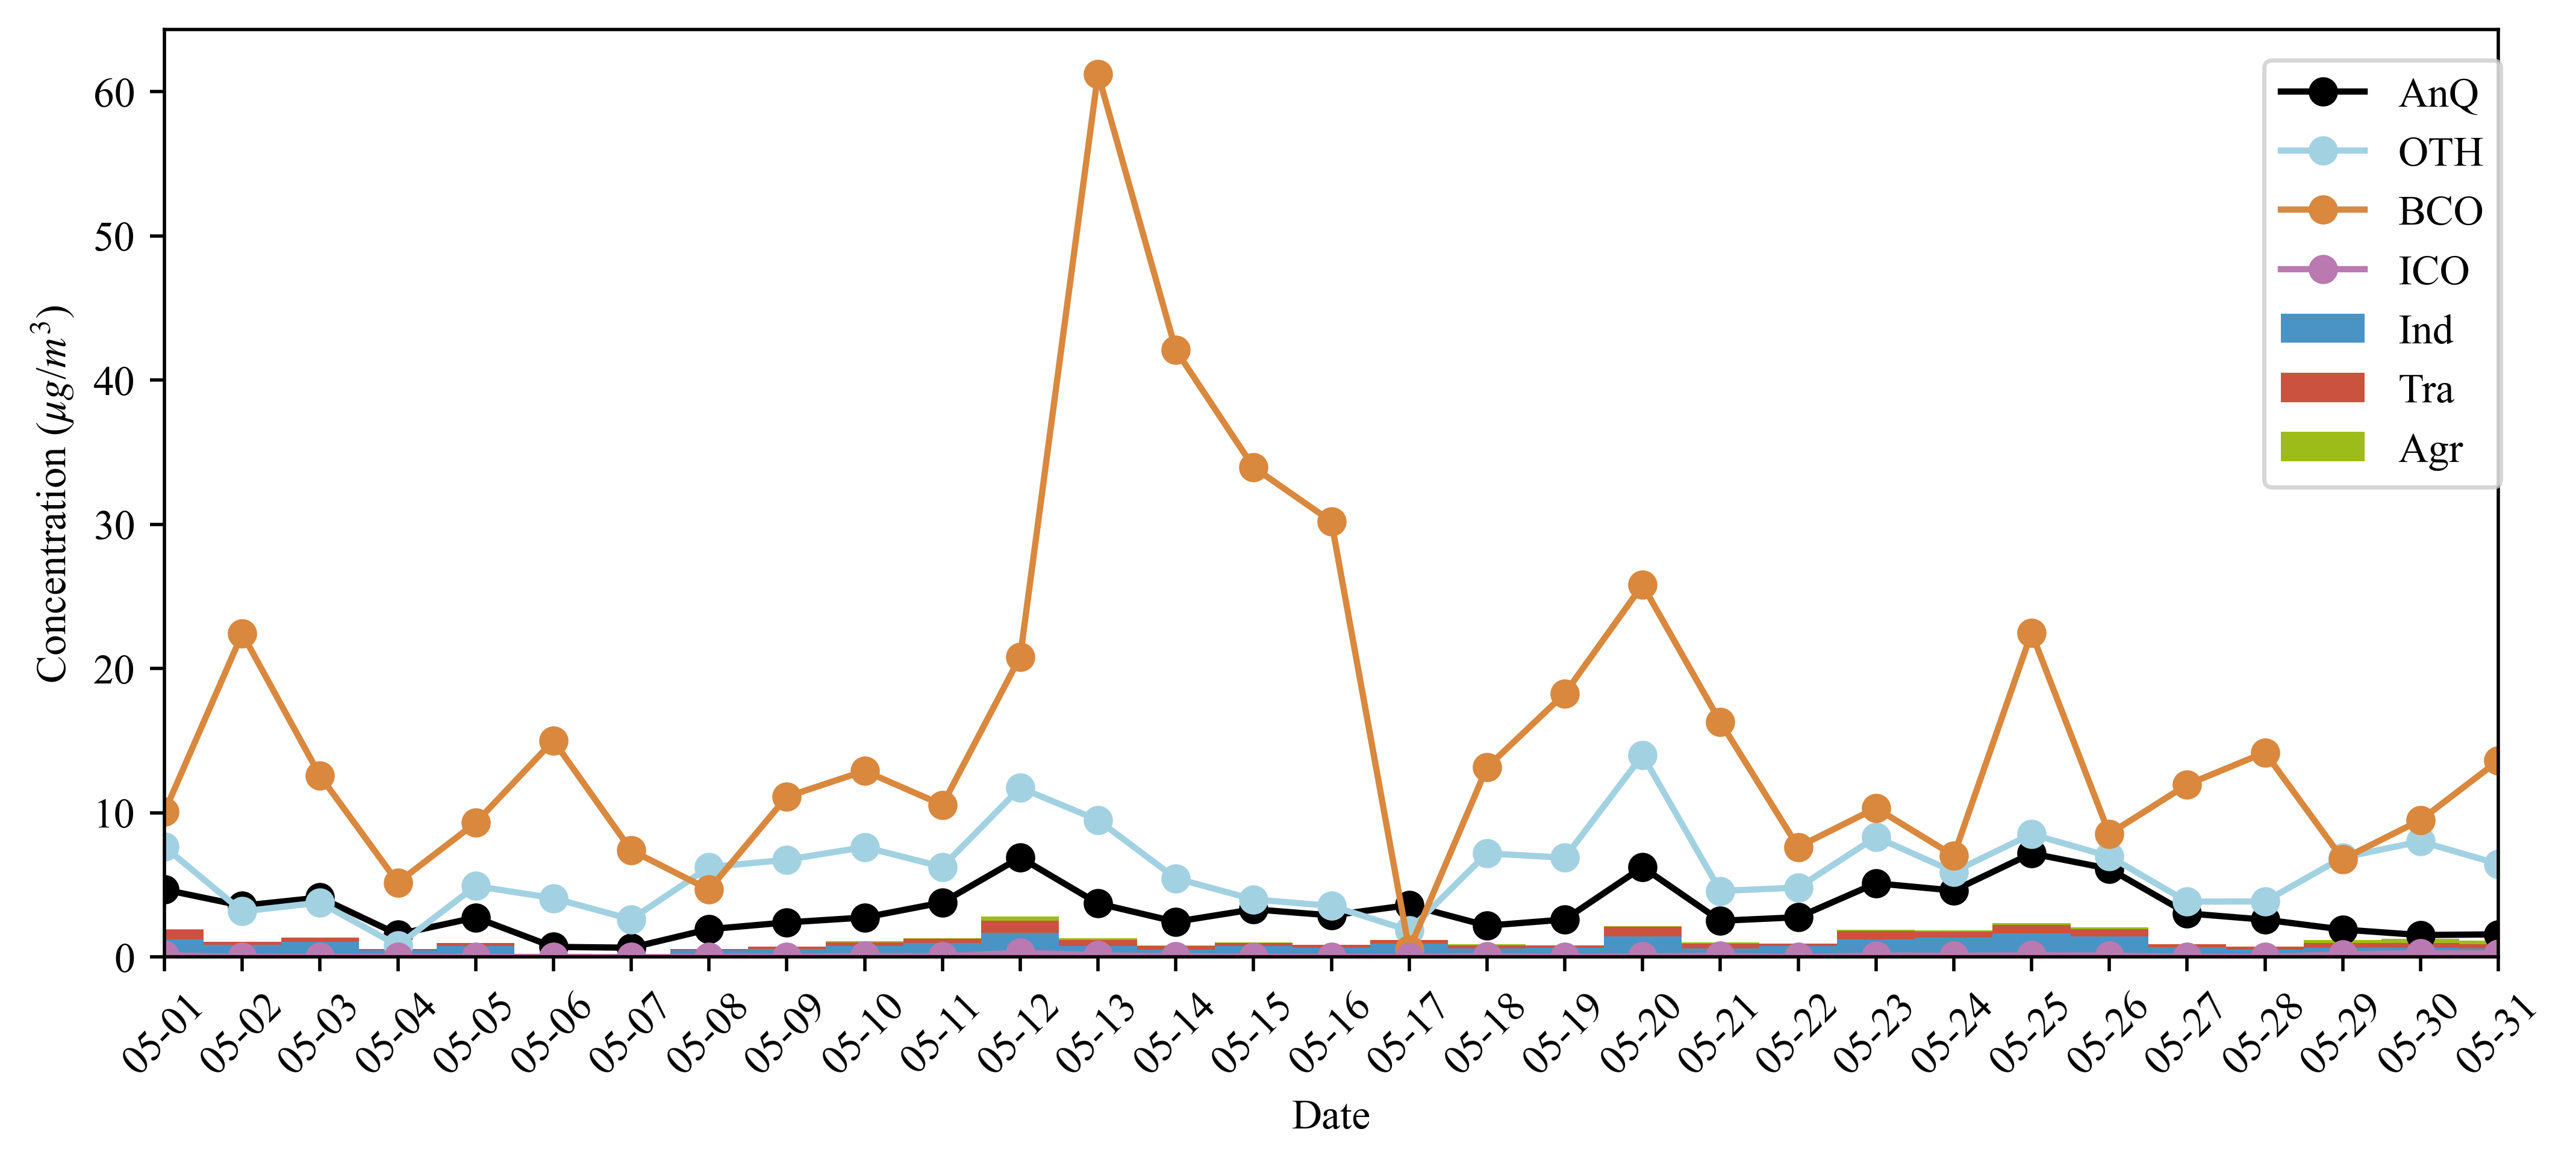

In [11]:
ts=np.arange(0,31)

colors = ['#4994c4','#cb523e','#9ebc19','#a2d2e2',
          '#d9883d','#ba79b1','#c8b5b3','#45465e']

fig,ax =plt.subplots(figsize=(10,4),dpi=500)

l1 = ax.plot(ts,df_avg['AnQ'],marker='.',markersize=12,color='k')
l2 = ax.plot(ts,df_avg['OTH'],marker='.',markersize=12,color=colors[3])
l3 = ax.plot(ts,df_avg['BCO'],marker='.',markersize=12,color=colors[4])
l4 = ax.plot(ts,df_avg['ICO'],marker='.',markersize=12,color=colors[5])

b1=ax.bar(ts,df_avg['AQI'],color=colors[0],width=1)
b2=ax.bar(ts,df_avg['AQT'],bottom=df_avg['AQI'],color=colors[1],width=1)
b3=ax.bar(ts,df_avg['AQA'],bottom=df_avg['AQT']+df_avg['AQI'],color=colors[2],width=1)

ax.legend((l1[0],l2[0],l3[0],l4[0],b1[0],b2[0],b3[0]),
          ('AnQ','OTH','BCO','ICO','Ind','Tra','Agr'),bbox_to_anchor=(1.01,0.99))
# ax.set_title('O$_3$ in urban Anqing',fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Concentration ($\mu$$g$/$m^3$)')
ax.set_xticks(np.arange(0,31))
ax.set_xticklabels(pd.date_range('2023-05-01','2023-05-31',freq='D').strftime('%m-%d'),rotation=45)
# ax.set_yticks(np.arange(0,61,10))
# ax.set_ylim(0,60)
ax.set_xlim(0,30)

plt.show()